# eQQMIX : Entangled Quantum QMIX Algorithm -- eQVDN

Multi-agent learning by deriving $Q_{tot}$ from GHZ-entangled agent PQCs and joint measurements.

Inspired by the tutorial: https://www.tensorflow.org/quantum/tutorials/quantum_reinforcement_learning#3_deep_q-learning_with_pqc_q-function_approximators

In [117]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
# warnings.filterwarnings('error', message=r".*complex128.*")
# warnings.simplefilter('module')

# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()

# from eqmarl import *
import cirq
import sympy
import tensorflow_quantum as tfq
import numpy as np
import functools as ft
import collections as cl
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import gymnasium as gym
from pathlib import Path
from PIL import Image

In [119]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [120]:
from time import perf_counter
from contextlib import contextmanager

@contextmanager
def catchtime() -> float:
    start = perf_counter()
    yield lambda: perf_counter() - start


# with catchtime() as t:
#     import time
#     time.sleep(1)

# print(f"Execution time: {t():.4f} secs")

In [121]:
def entangle_agents_phi_plus(qubits: list, d: int, n: int, op: cirq.Gate = cirq.CNOT):
    """Entangles via $\\Phi^+$."""
    ops = []
    for i in range(d):
        ops.append(cirq.H(qubits[i]))
        for j in range(n-1):
            ops.append(op(qubits[j*d + i], qubits[(j+1)*d + i]))
    return ops

In [122]:
class ParameterizedOperationGate(cirq.Gate):
    """
    Applies a sequence of gates corresponding to a parameter matrix. By default gates are assumed to operate on single qubits. Every row of the parameter matrix is a separate set of qubits on which to apply the operation sequence.
    """
    
    operations: list[cirq.Gate] = []
    
    def __init__(self, theta: np.ndarray, name: str = None):
        super().__init__()
        self.theta = theta
        self.name = name or self.__class__.__name__
        
    def _num_qubits_(self):
        return self.theta.shape[0]

    def _decompose_(self, qubits):
        # Decompose rotations into operations.
        for i, q in enumerate(qubits):
            for j, op in enumerate(self.operations):
                yield op(self.theta[..., i, j])(q)
                
    def _circuit_diagram_info_(self, args):
        return [f'{self.name}({self.theta[i]})' for i in range(self.theta.shape[0])]
    
    @classmethod
    def get_shape(cls,
        n_qubits: int,
        operations: list[cirq.Gate] = None,
        ):
        """Returns tuple of (n_wires, n_operations).
        
        If no operations are provided then defaults to class operations.
        
        Note that the returned shape does not include a batch dimension.
        """

        # Use default operations for class instance if none were provided.
        if operations is None: 
            operations = cls.operations

        return (n_qubits, len(operations),)


class VariationalRotationLayer(ParameterizedOperationGate):
    """Parameterized variational rotation layer.
    
    Implements `shape()` to determine parameter shapes.
    """
    operations = [cirq.rx, cirq.ry, cirq.rz] # Default is 3 rotation sequence RX, RY, RZ.


class EncodingLayer(ParameterizedOperationGate):
    """Parameterized variational rotation layer.
    
    Implements `shape()` to determine parameter shapes.
    """
    operations = [cirq.rx]


def circular_entangling_layer(
    qubits: list,
    gate: cirq.Gate = cirq.CZ,
    ) -> list[cirq.Operation]:
    """Entangles a list of qubits with their next-neighbor in circular fashion (i.e., ensures first and last qubit are also entangled)."""
    ops = []
    for q0, q1 in zip(qubits, qubits[1:]):
        ops.append(gate(q0, q1))
    if len(qubits) != 2:
        ops.append(gate(qubits[0], qubits[-1])) # Entangle the first and last qubit.
    return ops


def generate_partite_variational_encoding_circuit(
    qubits: list,
    n_parts: int, # Number of partitions.
    d_qubits: int, # Number of qubits per partition.
    n_layers: int,
    decompose: bool = False,
    ) -> tuple[cirq.Circuit, tuple[np.ndarray,...]]:
    
    shape_var = VariationalRotationLayer.get_shape(d_qubits)
    shape_enc = EncodingLayer.get_shape(d_qubits)
    
    ### Define weights for circuit.
    #
    ## Variational shape
    theta_var = sympy.symbols(f'var^{{(0:{n_parts})}}(0:{n_layers+1})_' + '_'.join(f'(0:{x})' for x in shape_var))
    theta_var = np.asarray(theta_var).reshape((n_parts, n_layers+1, *shape_var))
    ## Encoding shape
    theta_enc = sympy.symbols(f'enc^{{(0:{n_parts})}}(0:{n_layers})_' + '_'.join(f'(0:{x})' for x in shape_enc))
    theta_enc = np.asarray(theta_enc).reshape((n_parts, n_layers, *shape_enc))
    
    # Build the circuit.
    # circuit = cirq.Circuit()
    ops = []
    
    # Add GHZ entangling layer at the start.
    ops.append(
        entangle_agents_phi_plus(qubits, d_qubits, n_parts)
    )
    
    # Build circuit in partitions.
    for pidx in range(n_parts):
        qidx = pidx * d_qubits # Starting qubit index for the current partition.
    
        for l in range(n_layers):
            # Variational layer.
            ops.append(
                VariationalRotationLayer(theta_var[pidx, l], name=f'{pidx}-v{l}')(*qubits[qidx:qidx + d_qubits])
            )
            
            # Entangling layer.
            ops.append(
                circular_entangling_layer(qubits[qidx:qidx + d_qubits])
            )
            
            # Encoding layer.
            ops.append(
                EncodingLayer(theta_enc[pidx, l], name=f'{pidx}-e{l}')(*qubits[qidx:qidx + d_qubits])
            )
        # Last variational layer at the end.
        ops.append(
            VariationalRotationLayer(theta_var[pidx, l+1], name=f'v{l+1}')(*qubits[qidx:qidx + d_qubits])
        )
    
    # Decompose circuit into minimal gate representation.
    # This is required when custom gates are implemented for use with TensorFlowQuantum
    if decompose:
        ops = [cirq.decompose(o) for o in cirq.ops.flatten_to_ops(ops)]

    circuit = cirq.Circuit(ops)

    return circuit, (theta_var, theta_enc)
    

n_parts = 2
d_qubits = 4
n_layers = 5
    
qubits = cirq.LineQubit.range(n_parts * d_qubits)
# qubits

circuit, _ = generate_partite_variational_encoding_circuit(qubits, n_parts, d_qubits, n_layers, decompose=False)
circuit

# shape_var = VariationalRotationLayer.get_shape(qubits)
# theta_var = np.random.random(size=shape_var)

# shape_enc = EncodingLayer.get_shape(qubits)
# theta_enc = np.random.random(size=shape_enc)

# # VariationalRotationLayer(theta_var, name='vr')(*qubits)

# circuit = cirq.Circuit()
# circuit += VariationalRotationLayer(theta_var)(*qubits)
# circuit += EncodingLayer(theta_enc)(*qubits)

print(circuit)

          ┌────┐
0: ───H────@───────0-v0([var^{0}0_0_0 var^{0}0_0_1 var^{0}0_0_2])───@───────────@───0-e0([enc^{0}0_0_0])───0-v1([var^{0}1_0_0 var^{0}1_0_1 var^{0}1_0_2])───@───────────@───0-e1([enc^{0}1_0_0])───0-v2([var^{0}2_0_0 var^{0}2_0_1 var^{0}2_0_2])───@───────────@───0-e2([enc^{0}2_0_0])───0-v3([var^{0}3_0_0 var^{0}3_0_1 var^{0}3_0_2])───@───────────@───0-e3([enc^{0}3_0_0])───0-v4([var^{0}4_0_0 var^{0}4_0_1 var^{0}4_0_2])───@───────────@───0-e4([enc^{0}4_0_0])───v5([var^{0}5_0_0 var^{0}5_0_1 var^{0}5_0_2])───
           │       │                                                │           │   │                      │                                                │           │   │                      │                                                │           │   │                      │                                                │           │   │                      │                                                │           │   │                      │
1: ───H────┼@──

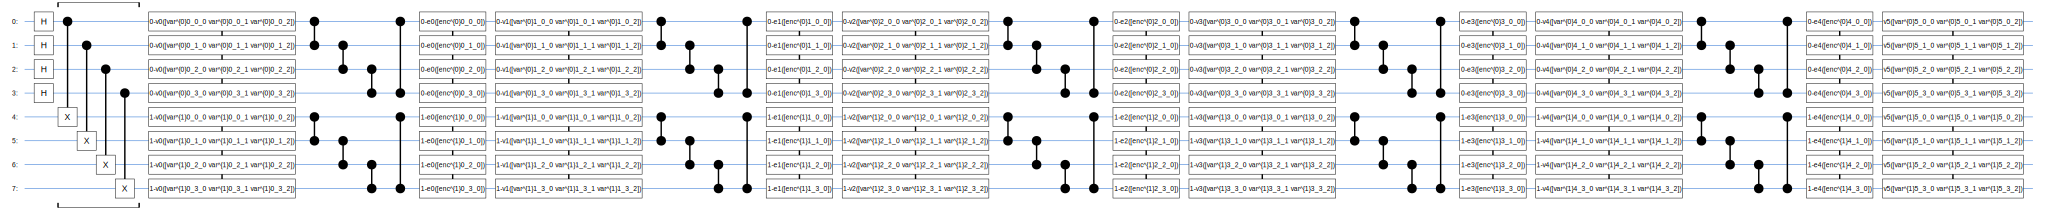

In [123]:
from cirq.contrib.svg import SVGCircuit
SVGCircuit(circuit)

In [124]:
class HybridPartiteVariationalEncodingPQC(keras.layers.Layer):
    
    def __init__(self, 
        qubits: list,
        n_parts: int, # Number of partitions.
        d_qubits: int, # Number of qubits per partition.
        n_layers: int,
        observables: list,
        name: str = None,
        squash_activation: str = 'linear',
        ):
        name = name or self.__class__.__name__
        super().__init__(name=name)
        
        self.n_layers = n_layers
        self.n_qubits = len(qubits)
        self.squash_activation = squash_activation
        
        # Build circuit.
        circuit, (symbols_var, symbols_enc) = self.generate_circuit(qubits, n_parts, d_qubits, n_layers, decompose=True)
        
        # Define trainable variables for TensorFlow layer.
        self.w_var = tf.Variable(
            initial_value=tf.random_uniform_initializer(minval=0.0, maxval=np.pi)(shape=symbols_var.shape, dtype='float32'),
            trainable=True,
            name='w_var',
        )
        self.w_enc = tf.Variable(
            initial_value=tf.ones(shape=symbols_enc.shape, dtype='float32'),
            trainable=True,
            name='w_enc',
        )
        
        # print(f"{self.w_var.shape=}")
        # print(f"{self.w_enc.shape=}")
        
        # Explicit symbol ordering.
        self.symbols = [str(s) for s in np.concatenate((symbols_var.flatten(), symbols_enc.flatten()))]
        self.symbols_idx = tf.constant([self.symbols.index(s) for s in sorted(self.symbols)]) # Cross-ref symbol with its index in the explicit ordering.
        
        # Empty circuit for batching.
        self.empty_circuit_tensor = tfq.convert_to_tensor([cirq.Circuit()])
        
        # The variational+encoding circuit for computation.
        self.computation_layer = tfq.layers.ControlledPQC(circuit, observables)
        
    def call(self, inputs):
        batch_size = tf.gather(tf.shape(inputs), 0)
        
        # Since input is batched, we must batch the TFQ circuits.
        batched_circuits = tf.repeat(self.empty_circuit_tensor, repeats=batch_size)
        
        # Batch the variational weight angles.
        angles_var = tf.reshape(tf.tile(self.w_var, multiples=[batch_size, *([1]*(len(self.w_var.shape)-1))]), shape=(-1, *self.w_var.shape))
        # print(f"{self.w_var.shape=}")
        # print(f"{angles_var.shape=}")
        
        # Multiply input vectors by the encoding weights.
        # Preserves batching.
        # Einsum dimension labels:
        #   p = partition index
        #   b = batch
        #   l = layer
        #   q = qubit
        #   f = feature
        # angles_enc = tf.einsum("lqf,bq->blqf", self.w_enc, inputs)
        angles_enc = tf.einsum("plqf,bpq->bplqf", self.w_enc, inputs) # For each partition `p`, encode each `input` state feature `q` on the `q-th` qubit and repeat encoding on same qubit for every layer `l`. Number of input features must match number of qubits.
        
        # Squash the encoding input angles using the provided activation function.
        angles_enc = keras.layers.Activation(self.squash_activation)(angles_enc)
        
        
        # Combine all angles into a single batched tensor.
        # This is necessary because TensorFlowQuantum requires parameters to be in 1D list format. Since the circuits are also batched, this turns into 2D with shape (batch_size, num_symbols).
        #
        # Since all angles are different shapes, compress each down to batched 2D and then concatenate along the feature dimension.
        joined_angles = tf.concat([
            tf.reshape(angles_var, (batch_size, -1)),
            tf.reshape(angles_enc, (batch_size, -1)),
        ], axis=1)
        #
        # Now reorder angles based on explicit symbol ordering.
        joined_angles = tf.gather(joined_angles, self.symbols_idx, axis=1)
        
        # Run batched angles.
        # Result will be 2D with shape (batch_size, num_observables).
        out = self.computation_layer([batched_circuits, joined_angles])
        
        return out
    
    @staticmethod
    def generate_circuit(*args, **kwargs):
        return generate_partite_variational_encoding_circuit(*args, **kwargs)

n_parts = 2
d_qubits = 4
n_layers = 5

qubits = cirq.LineQubit.range(n_parts * d_qubits)

observables = [
    cirq.Z(qubits[0]) * cirq.Z(qubits[1]) * cirq.Z(qubits[4]) * cirq.Z(qubits[5]), # 0,0
    cirq.Z(qubits[0]) * cirq.Z(qubits[1]) * cirq.Z(qubits[6]) * cirq.Z(qubits[7]), # 0,1
    cirq.Z(qubits[2]) * cirq.Z(qubits[3]) * cirq.Z(qubits[4]) * cirq.Z(qubits[5]), # 1,0
    cirq.Z(qubits[2]) * cirq.Z(qubits[3]) * cirq.Z(qubits[6]) * cirq.Z(qubits[7]), # 1,1
]
    
layer = HybridPartiteVariationalEncodingPQC(qubits, n_parts, d_qubits, n_layers, observables, squash_activation='tanh')
layer.w_var.shape, layer.w_enc.shape, layer.symbols, layer.symbols_idx


x = np.random.random(size=(16,2, 4,))
layer(x)

<tf.Tensor: shape=(16, 4), dtype=float32, numpy=
array([[-0.07378229,  0.16047229,  0.228633  , -0.08520135],
       [ 0.11475238, -0.03858126, -0.06718771, -0.01873802],
       [-0.12432625,  0.00780364,  0.11365373, -0.03111299],
       [ 0.01974263, -0.00497477, -0.06722055, -0.04602515],
       [-0.09622704,  0.12515613,  0.11291685,  0.13198482],
       [-0.01610178,  0.03089723,  0.07789475, -0.16885936],
       [-0.13728262,  0.11368296,  0.186133  ,  0.12758824],
       [-0.02990755,  0.10074172,  0.0491792 ,  0.16332279],
       [-0.04979756,  0.11829554,  0.10881795, -0.02841842],
       [-0.01550733,  0.06831758,  0.00531804,  0.01124211],
       [-0.09878839,  0.16184685,  0.12681271,  0.08324908],
       [-0.04150113,  0.0406177 , -0.09948614, -0.03178011],
       [-0.1156123 ,  0.10824063,  0.12716903,  0.06593142],
       [-0.14341167,  0.02297893,  0.05263877,  0.07267224],
       [-0.06702487, -0.06815886,  0.0642936 , -0.00102341],
       [ 0.00345183,  0.02606668,  0

In [125]:
class Rescaling(keras.layers.Layer):
    """Learnable rescaling from range [-1, 1] to range [0, 1]."""
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim
        self.w = tf.Variable(
            initial_value=tf.ones(shape=(1,input_dim)),
            dtype='float32',
            trainable=True,
            name='obs-weights',
            )
        
    def call(self, inputs):
        # inputs = tf.math.abs(inputs)
        # inputs = tf.cast(inputs, dtype='float32')
        return tf.math.multiply(
            (1+inputs)/2., # Rescale from [-1, 1] to range [0, 1].
            tf.repeat(self.w, repeats=tf.shape(inputs)[0], axis=0),
            )

In [126]:
def generate_model_eqqmix(
    qubits,
    n_agents,
    d_qubits,
    n_layers,
    observables,
    is_target,
    ):
    
    # n_wires = len(qubits)
    
    # qubits = cirq.LineQubit.range(n_wires)
    
    qlayer = HybridPartiteVariationalEncodingPQC(
        qubits=qubits, 
        n_parts=n_agents,
        d_qubits=d_qubits,
        n_layers=n_layers,
        observables=observables,
        squash_activation='tanh',
        )

    model = keras.Sequential([
            keras.Input(shape=(n_agents, d_qubits,), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the observation vector shape.
            qlayer,
            # CustomQuantumLayer(n_wires, n_layers, observables),
            # keras.layers.Lambda(lambda x: tf.math.abs(x)), # Convert complex to float via abs.
            # keras.layers.Activation('tanh'), # Ensure outputs of PQC are in range [-1, 1].
            keras.Sequential([Rescaling(len(observables))], name=is_target*'Target'+'Q-values'),
        ],
        )
    return model
    

In [127]:
import itertools
import functools

def make_observables_cartpole(qubits: list) -> list:
    return [
        cirq.Z(qubits[0]) * cirq.Z(qubits[1]),
        cirq.Z(qubits[2]) * cirq.Z(qubits[3]),
    ]
    
def permute_observables(observables: list[list]) -> list:
    return [
        functools.reduce(lambda x, y: x*y, obs)
        for obs in itertools.product(*observables)
        ]


# n_agents = 4

# qubits = cirq.LineQubit.range(n_agents * d_qubits)



# agent_obs = []
# for aidx in range(n_agents):
#     qidx = aidx * d_qubits # Starting qubit index for the current partition.
    
#     obs = make_observables_cartpole(qubits[qidx:qidx+d_qubits])
#     agent_obs.append(obs)

# # agent_obs, permute_observables(agent_obs)

# # # agent_obs = [
# # #     make_observables_cartpole(qubits[]) for i in range(n_agents)
# # #     ]

In [128]:
# n_actions = 2 # because `env.action_space.n == 2`
# n_wires = 4 # because `env.observation_space.shape == (4,)`
# n_layers = 5

n_agents = 4
d_qubits = 4
n_layers = 5

n_actions = 2 # because `env.action_space.n == 2`

qubits = cirq.LineQubit.range(n_agents * d_qubits)

# observables = [
#     cirq.Z(qubits[0]) * cirq.Z(qubits[1]) * cirq.Z(qubits[4]) * cirq.Z(qubits[5]), # 0,0
#     cirq.Z(qubits[0]) * cirq.Z(qubits[1]) * cirq.Z(qubits[6]) * cirq.Z(qubits[7]), # 0,1
#     cirq.Z(qubits[2]) * cirq.Z(qubits[3]) * cirq.Z(qubits[4]) * cirq.Z(qubits[5]), # 1,0
#     cirq.Z(qubits[2]) * cirq.Z(qubits[3]) * cirq.Z(qubits[6]) * cirq.Z(qubits[7]), # 1,1
# ]

agent_obs = []
for aidx in range(n_agents):
    qidx = aidx * d_qubits # Starting qubit index for the current partition.
    
    obs = make_observables_cartpole(qubits[qidx:qidx+d_qubits])
    agent_obs.append(obs)

observables = permute_observables(agent_obs)

# Joint action --> per-agent action
joint_action_map = list(itertools.product(*list(itertools.repeat(list(range(n_actions)), n_agents))))
# joint_action_map = [
#     (0,0),
#     (0,1),
#     (1,0),
#     (1,1),
# ]

In [129]:
model = generate_model_eqqmix(
    qubits=qubits,
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    observables=observables,
    is_target=False,
    )

model_target = generate_model_eqqmix(
    qubits=qubits,
    n_agents=n_agents,
    d_qubits=d_qubits,
    n_layers=n_layers,
    observables=observables,
    is_target=True,
    )

print('setting weights')
model_target.set_weights(model.get_weights())

setting weights


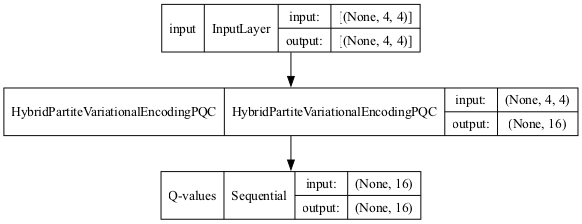

In [130]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70, to_file="model_classic.png")

In [131]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HybridPartiteVariationalEnc  (None, 16)               368       
 odingPQC (HybridPartiteVari                                     
 ationalEncodingPQC)                                             
                                                                 
 Q-values (Sequential)       (None, 16)                16        
                                                                 
Total params: 384
Trainable params: 384
Non-trainable params: 0
_________________________________________________________________


In [132]:
# x = np.random.random(size=(64, n_parts, 4,))
# model([x])

## Training

In [133]:
gamma = 0.99
n_episodes = 2000

# Define replay memory
max_memory_length = 10000 # Maximum replay length
replay_memory = cl.deque(maxlen=max_memory_length)
# agent_replay_memory = [cl.deque(maxlen=max_memory_length) for i in range(n_agents)] # Separate replay memory for each agent.

epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.01  # Minimum epsilon greedy parameter
decay_epsilon = 0.99 # Decay rate of epsilon greedy parameter
batch_size = 16
steps_per_update = 10 # Train the model every x steps
steps_per_target_update = 30 # Update the target model every x steps

optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2

# optimizer_w_tups = list(zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]))

In [134]:
### Q-learning update function.

# @tf.function
def eqqmix_update(states, actions, rewards, next_states, done, model, model_target, gamma, n_actions):
    
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    rewards = tf.convert_to_tensor(rewards)
    next_states = tf.convert_to_tensor(next_states)
    done = tf.convert_to_tensor(done)
    
    # Convert termination signals into a joint signal.
    done = tf.reduce_prod(done, axis=1)
    
    # Convert individual rewards into a joint reward.
    rewards = tf.reduce_mean(rewards, axis=1)
    
    # print(f"{states=}")
    # print(f"{actions=}")
    # print(f"{rewards=}")
    # print(f"{next_states=}")
    # print(f"{done=}")
    # print(f"{tf.reduce_prod(done, axis=1)=}")
    

    # Compute target Q-values and masks on sampled actions.
    # with catchtime() as t:
    future_rewards = model_target([next_states])
    # print(f"{future_rewards=}")
    # print(f"{tf.reduce_max(future_rewards, axis=1)=}")
    # print(f"{tf.reduce_max(future_rewards, axis=-1)=}")
    target_q_values = rewards + (gamma * tf.reduce_max(future_rewards, axis=1) * (1. - done))
    # print(f"{target_q_values=}")
    # print(f"[target_q_values] Execution time: {t():.4f} secs")
    
    # masks = tf.one_hot(actions, n_agents * n_actions)
    masks = tf.one_hot(actions, n_actions ** n_agents)
    # print(f"{actions=}")
    # print(f"{masks=}")
    
    
    # with catchtime() as t:
    # Train the model using target Q-values.
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        # with catchtime() as t1:
        q_values = model([states])
        # print(f"[tape:eval] Execution time: {t1():.4f} secs")
        # print(f"{q_values=}")
        q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        # print(f"{q_values_masked=}")
        loss = tf.keras.losses.Huber()(target_q_values, q_values_masked)
    # print(f"[tape] Execution time: {t():.4f} secs")
        
    # with catchtime() as t:
    # Backprop.
    grads = tape.gradient(loss, model.trainable_variables)
    # for optimizer, w in optimizer_w_tups:
    for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]):
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])
    # print(f"[backprop] Execution time: {t():.4f} secs")
        
    # # print(f"{loss=}")
    # # print(f"{grads=}")
    # # print(f"{masks=}")
    # print(f"{target_q_values=}")
    # print(f"{q_values=}")
    # print(f"{loss=}")
    # print(f"{grads=}")

In [135]:
# def interact_env(state, model, epsilon, n_actions, env):
#     # state_shape = state.shape
#     # state = np.asarray(state).reshape((1, *state_shape)) # Reshape to (1, features) so that batch_size=1.
#     # state = tf.convert_to_tensor([state]) # Reshape to (1, features) so that batch_size=1.
#     state = np.asarray(state).reshape((1, 4)) # Reshape to (1, features) so that batch_size=1.
    
#     # Select action.
#     coin = np.random.random()
#     if coin > epsilon: # Epsilon-greedy
#         q_vals = model([state])
#         action = int(tf.argmax(q_vals[0]).numpy())
#     else: # Random action.
#         action = np.random.choice(n_actions)
    
#     next_state, reward, done, _, _ = env.step(action)
#     next_state = np.asarray(next_state).reshape(state.shape)
    
#     return dict(
#         state=state,
#         action=action,
#         reward=reward,
#         next_state=next_state,
#         done=done,
#     )
    
def interact_partite_envs(
    states,
    n_agents,
    model,
    epsilon,
    envs,
    joint_action_map,
    ):
    
    states = np.asarray(states).reshape((1, n_agents, d_qubits)) # Reshape to (1, n_agents, features) so that batch_size=1.

    # Select action.
    coin = np.random.random()
    if coin > epsilon: # Epsilon-greedy
        q_vals = model([states])
        joint_action = int(tf.argmax(q_vals[0]).numpy())
    else: # Random action.
        joint_action = np.random.choice(n_agents * n_actions)

    agent_actions = joint_action_map[joint_action]
    rewards = []
    dones = []
    next_states = []
    for aidx in range(n_agents):
        next_state, reward, done, _, _ = envs[aidx].step(agent_actions[aidx])
        
        rewards.append(reward)
        dones.append(done)
        next_states.append(next_state)
    
    next_states = np.asarray(next_states).reshape(states.shape)
        
    return dict(
        states=states,
        joint_action=joint_action,
        rewards=rewards,
        next_states=next_states,
        dones=dones,
    )

In [136]:
### NEW eQQMIX TRAINING LOOP

envs = [gym.make('CartPole-v1') for i in range(n_agents)]

# print(np.asarray(states).reshape((1, n_agents, 4)).shape)

episode_reward_history = []
step_count = 0

for episode in range(n_episodes):
    episode_reward = 0
    
    # Reset environments.
    states = []
    for i in range(n_agents):
        state, _ = envs[i].reset()
        states.append(state)

    while True:
        interaction = interact_partite_envs(
            states=states,
            n_agents=n_agents,
            model=model,
            epsilon=epsilon,
            envs=envs,
            joint_action_map=joint_action_map,
        )
        replay_memory.append(interaction)
        
        # print(f"{interaction['rewards']=},  {interaction['dones']=}")
        # print(f"{interaction['dones']=}")
        
        states = interaction['next_states']
        episode_reward += tf.reduce_mean(interaction['rewards'])
        step_count += 1
        
        if step_count % steps_per_update == 0:
            training_batch = np.random.choice(replay_memory, size=batch_size) # Randomly select interactions from replay memory and train on them.
            # print(f"{training_batch=}")

            eqqmix_update(
                states=np.asarray([x['states'] for x in training_batch]).squeeze(),
                actions=np.asarray([x['joint_action'] for x in training_batch]).squeeze(),
                rewards=np.asarray([x['rewards'] for x in training_batch], dtype=np.float32).squeeze(),
                next_states=np.asarray([x['next_states'] for x in training_batch]).squeeze(),
                done=np.asarray([x['dones'] for x in training_batch], dtype=np.float32).squeeze(),
                model=model,
                model_target=model_target,
                gamma=gamma,
                n_actions=n_actions,
                # optimizer_w_tups=optimizer_w_tups,
                )
            # print('update')

        if step_count % steps_per_target_update == 0:
            model_target.set_weights(model.get_weights())
        
        # print(f"{any(interaction['dones'])=}, {interaction['dones']=}")
        if any(interaction['dones']):
            break
        
    # Decay epsilon.
    epsilon = max(epsilon * decay_epsilon, epsilon_min)
    episode_reward_history.append(episode_reward)

    if (episode+1) % 10 == 0:
        avg_rewards = np.mean(episode_reward_history[-10:])
        print("Episode {}/{}, average last 10 rewards {}".format(episode+1, n_episodes, avg_rewards))
        if avg_rewards >= 500.0:
            break
    
    # if episode > 50: break

Episode 10/2000, average last 10 rewards 9.600000381469727
Episode 20/2000, average last 10 rewards 9.300000190734863
Episode 30/2000, average last 10 rewards 9.399999618530273
Episode 40/2000, average last 10 rewards 9.399999618530273
Episode 50/2000, average last 10 rewards 9.600000381469727
Episode 60/2000, average last 10 rewards 9.100000381469727
Episode 70/2000, average last 10 rewards 9.199999809265137
Episode 80/2000, average last 10 rewards 9.0
Episode 90/2000, average last 10 rewards 9.300000190734863
Episode 100/2000, average last 10 rewards 9.199999809265137
Episode 110/2000, average last 10 rewards 8.800000190734863
Episode 120/2000, average last 10 rewards 8.699999809265137


KeyboardInterrupt: 

In [22]:
# model.save('q_qlearning_cirq', save_format='tf')
model.save_weights('q_eqqmix_cirq__weights')

In [23]:
model.load_weights('q_eqqmix_cirq__weights')

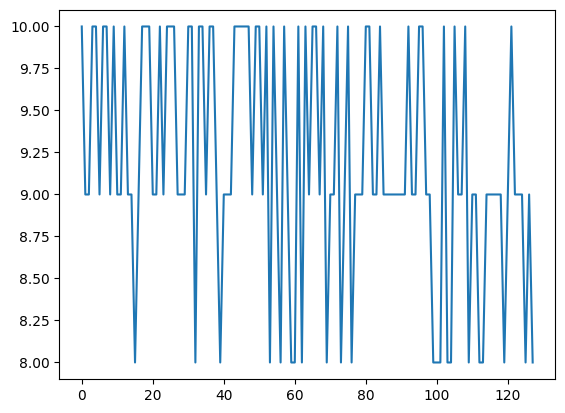

In [137]:
plt.plot(episode_reward_history)